#Data Analysis
We use the dataset from [Kaggle](https://www.kaggle.com/datasets/alessandrasala79/ai-vs-human-generated-dataset), which contains both AI-generated and real human-created images.

## Loading Dataset from Kaggle
In this subsection, we will load the dataset from Kaggle.
The dataset is already organized into separate train and test folders.

We will also read and store the paths to these images for further preprocessing and usage.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")

print("Path to dataset files:", path)

100%|██████████| 9.76G/9.76G [01:56<00:00, 89.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alessandrasala79/ai-vs-human-generated-dataset/versions/4


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from IPython.display import display
import seaborn as sns
import time

In [ ]:
TRAIN_CSV = path + '/train.csv'
TEST_CSV = path + '/test.csv'
DATA_DIR = path

## Dataset Properties
This dataset includes:
- **Train set**: 79.950 Images
- **Test set**: 5540 Images
- **train.csv**: Contains filenames and corresponding labels for the training set
- **test.csv**: Contains filenames and corresponding labels for the test set



In [ ]:
train_df = pd.read_csv(TRAIN_CSV)
train_df = train_df[['file_name','label']]
train_df.columns = ['id','label']
train_df.head()

,id,label
0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1


In [ ]:
test_df = pd.read_csv(TEST_CSV)
test_df.head()

,id
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg


In [ ]:
print('Train set: ', len(train_df))
print('Test set: ', len(test_df))

Train set:  79950
Test set:  5540


## Null Values Check
Before preprocessing, we check the dataset for any missing or corrupt data.

In [ ]:
print("Train null counts: ")
print(train_df.isnull().sum())
print("Test null counts: ")
print(test_df.isnull().sum())

Train null counts: 
id       0
label    0
dtype: int64
Test null counts: 
id    0
dtype: int64


Both the train and test datasets contain **no null values**.

This means we can safely proceed to the next step without handling missing data.

## File Existence Check
Before continuing, we ensure that all image files listed in the CSV files actually exist in the dataset folders.

In [ ]:
def check_file_existence(df):
  missing = []
  for fname in df['id']:
    if not os.path.isfile(os.path.join(DATA_DIR, fname)):
      missing.append(fname)
  return missing
train_missing = check_file_existence(train_df)
test_missing = check_file_existence(test_df)

print(f'Missing train: {len(train_missing)}/{len(train_df)}')
print(f'Missing test: {len(test_missing)}/{len(test_df)}')

Missing train: 0/79950
Missing test: 0/5540


If both results show **0 missing**, all files are correctly linked and the dataset is complete.

## Add Full Image Paths
To make image loading easier during preprocessing and training, we convert all image filenames in the DataFrame to full paths.

In [ ]:
train_df['id'] = train_df['id'].apply(lambda x: os.path.join(DATA_DIR, x))
test_df['id'] = test_df['id'].apply(lambda x: os.path.join(DATA_DIR, x))

## Create Image Pairs
In this step, we pair real images with their corresponding AI-generated images.

In [ ]:
train_df['pair_id'] = train_df.index //2
train_df.head()

,id,label,pair_id
0,/root/.cache/kagglehub/datasets/alessandrasala...,1,0
1,/root/.cache/kagglehub/datasets/alessandrasala...,0,0
2,/root/.cache/kagglehub/datasets/alessandrasala...,1,1
3,/root/.cache/kagglehub/datasets/alessandrasala...,0,1
4,/root/.cache/kagglehub/datasets/alessandrasala...,1,2


## Class Balance
We analyze the class distribution of the dataset to ensure that the labels are balanced.

Visualizing the class distribution helps identify if any class is underrepresented or overrepresented, which can guide decisions about whether to apply techniques like oversampling, undersampling, or class-weight adjustment during model training.

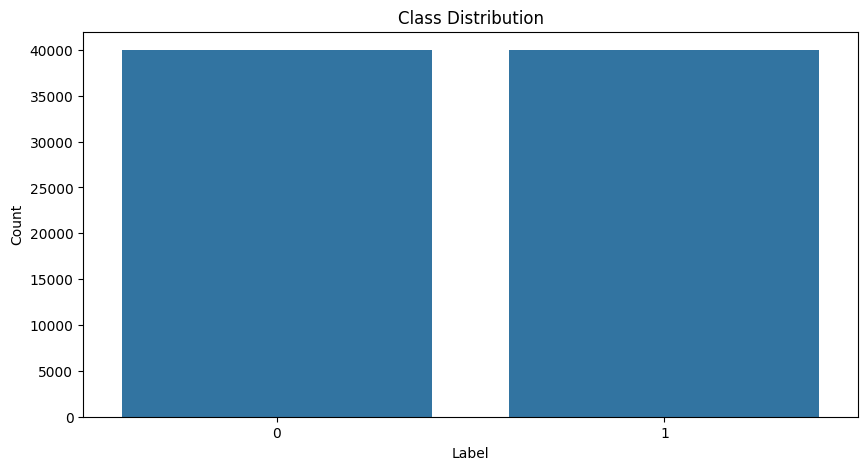

In [ ]:
# Class balance
label_counts = train_df["label"].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

The class distribution is balanced, with both classes containing an equal number of instances. This means that we don't need to apply any special techniques like oversampling or undersampling to address class imbalance. Both classes are represented fairly, which is ideal for training a well-balanced model.

## Pairing Violations Check
The output shows how many pairs have violated the expected label pairing. For instance, if two consecutive images both belong to the "real" class, it would be considered a violation.

In [ ]:
pair_violations = sum(train_df['label'].diff()[1::2]!= -1) # think of it as if there are 2 of the same labels next to each other it would be 0
print(f'Pairing violations: {pair_violations}/{len(train_df)//2}')

Pairing violations: 0/39975


## Pair Completeness Check
Ideally, every pair should have exactly 2 images — one real and one AI-generated. The output will show if any pairs have more or fewer than 2 images, which could indicate data integrity issues.

In [ ]:
# Pair completeness check
pair_sizes = train_df.groupby("pair_id")["id"].count().value_counts()
print("\nPair size distribution:")
print(pair_sizes)


Pair size distribution:
id
2    39975
Name: count, dtype: int64


## Image Metadata Analysis
In this step, we perform a detailed analysis of the image metadata to better understand the properties of the images in the dataset. This analysis includes:
1. Sampling: We randomly sample a subset of the images from the training set (default size: 10,000) to extract metadata.
2. Dimensions Analysis: We analyze the width and height of the images to understand the resolution distribution. This includes calculating the average dimensions and generating summary statistics (mean, min, max, etc.).
3. Format Distribution: We examine the distribution of different image formats (e.g., JPEG, PNG) to check for any inconsistencies in the types of images.
4. Channel Distribution: We analyze the number of color channels (e.g., RGB has 3 channels) to ensure consistency in the dataset's image types (e.g., grayscale vs. color images).

=== Image Metadata Analysis ===


Processing images: 100%|██████████| 10000/10000 [00:10<00:00, 953.99it/s]



=== Dimension Statistics ===
Average dimensions: 715.8x571.1
Dimension distribution:
              width        height
count  10000.000000  10000.000000
mean     715.752000    571.080000
std      101.552037    119.628153
min      320.000000    112.000000
25%      768.000000    512.000000
50%      768.000000    512.000000
75%      768.000000    672.000000
max      768.000000    768.000000


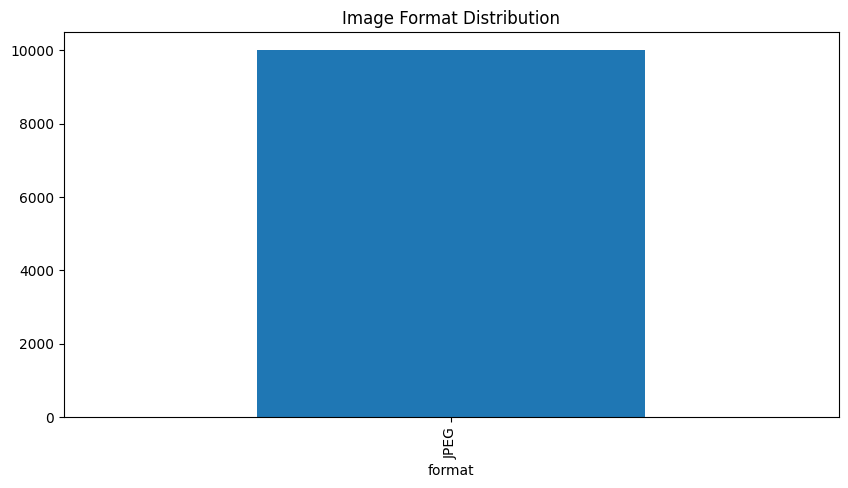


Channel distribution:
channels
3    9977
1      23
Name: count, dtype: int64


In [ ]:
def analyze_image_metadata(train_df, sample_size=10000):
    print("=== Image Metadata Analysis ===")

    # Sampling
    sample = train_df.sample(sample_size, random_state=42)
    metadata = []

    for _, row in tqdm(sample.iterrows(), total=sample_size, desc="Processing images"):
        img_path = row['id']
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                mode = img.mode
                format_ = img.format
        except:
            width, height, mode, format_ = (None,)*4

        metadata.append({
            "width": width,
            "height": height,
            "channels": len(mode) if mode else None,
            "format": format_
        })

    meta_df = pd.DataFrame(metadata)

    # Dimension analysis
    print("\n=== Dimension Statistics ===")
    print(f"Average dimensions: {meta_df['width'].mean():.1f}x{meta_df['height'].mean():.1f}")
    print("Dimension distribution:")
    print(meta_df[['width', 'height']].describe())

    # Format distribution
    plt.figure(figsize=(10, 5))
    meta_df['format'].value_counts().plot(kind='bar')
    plt.title("Image Format Distribution")
    plt.show()

    # Channel analysis
    channel_dist = meta_df['channels'].value_counts()
    print("\nChannel distribution:")
    print(channel_dist)

    return meta_df

meta_df = analyze_image_metadata(train_df)

## Visual Pattern Analysis
In this step, we visualize a sample of images from the dataset to analyze the patterns in the data visually. This helps to gain a better understanding of the image quality and characteristics for each label (e.g., human-created vs. AI-generated).

=== Visual Pattern Analysis ===


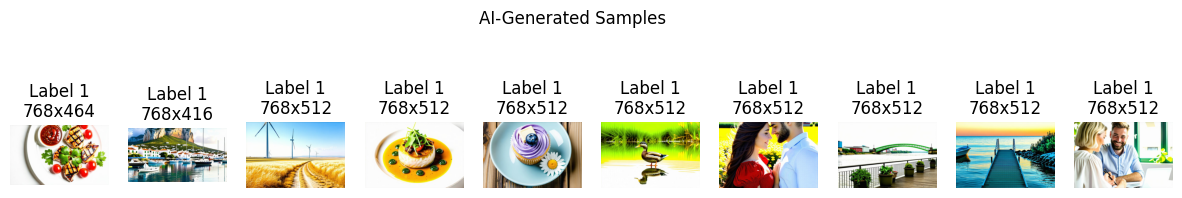

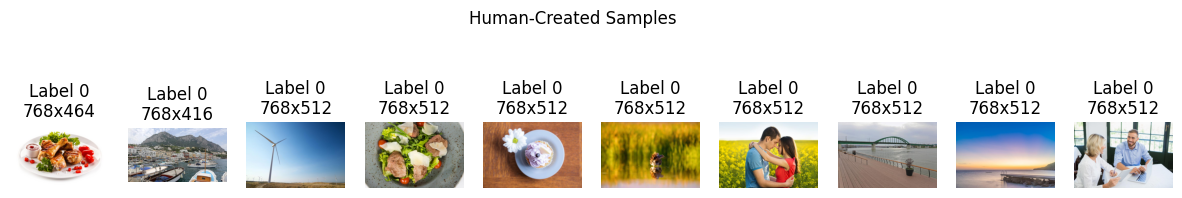

In [ ]:
def visualize_image_samples(train_df, n_samples=5):
    print("=== Visual Pattern Analysis ===")

    def plot_comparison(label, title):
        plt.figure(figsize=(15, 3))
        samples = train_df[train_df['label'] == label].sample(n_samples, random_state=42)
        for i, (_, row) in enumerate(samples.iterrows()):
            img_path = row['id']
            try:
                img = Image.open(img_path)
                plt.subplot(1, n_samples, i+1)
                plt.imshow(img)
                plt.title(f"Label {label}\n{img.size[0]}x{img.size[1]}")
                plt.axis('off')
            except:
                plt.title("Failed to load")
        plt.suptitle(title)
        plt.show()

    # Compare AI vs Human
    plot_comparison(1, "AI-Generated Samples")
    plot_comparison(0, "Human-Created Samples")

visualize_image_samples(train_df,10)

## Pixel Intensity Distribution Comparison
In this step, we compare the pixel intensity distribution between AI-generated images and human-created images.

 This helps analyze how the pixel intensity values (grayscale) differ between the two categories and provides insights into the image characteristics such as brightness and contrast.

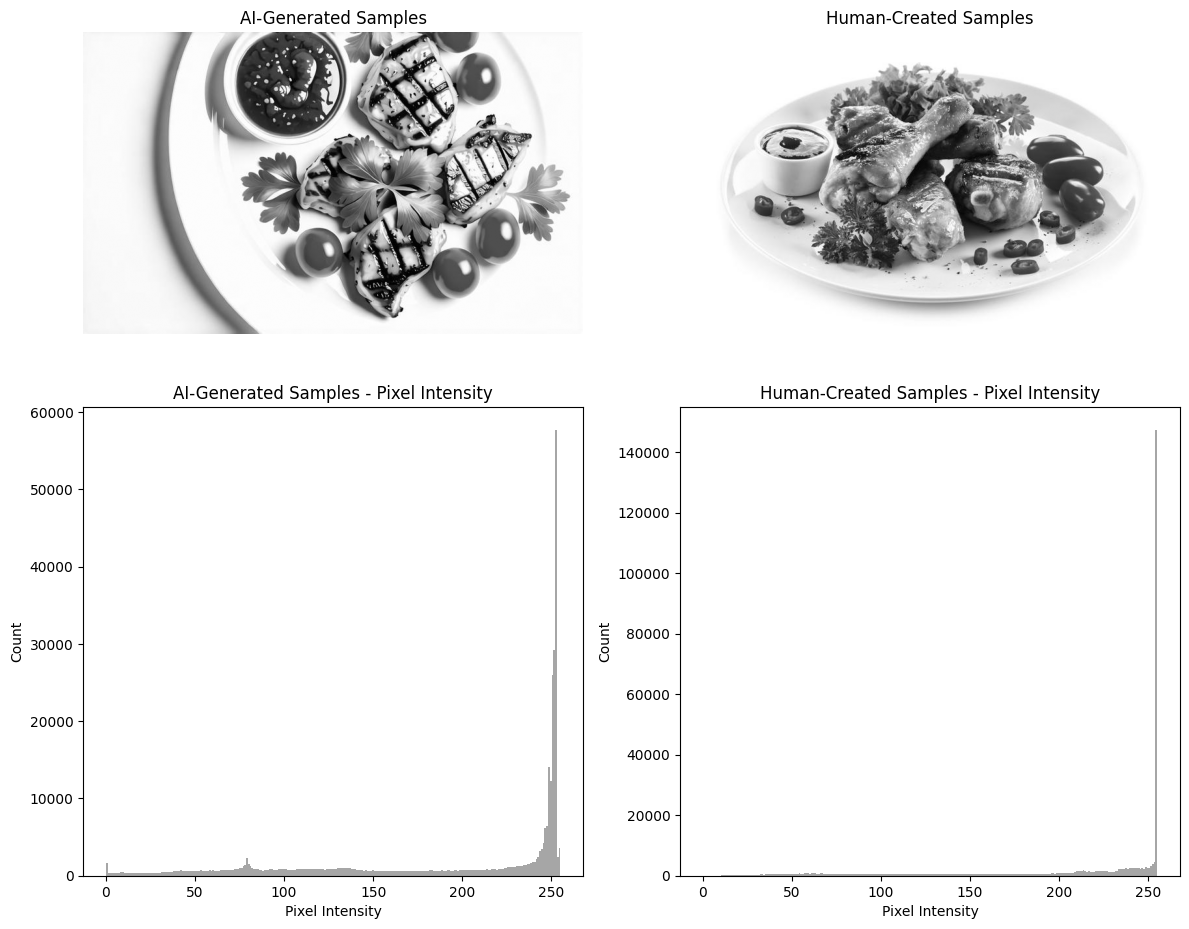

In [ ]:
def plot_pixel_intensity_side_by_side(img1_path,img2_path,title1 = "AI-Generated Samples", title2 = "Human-Created Samples"):
  img1 = cv2.imread(img1_path,cv2.IMREAD_GRAYSCALE)
  img2 = cv2.imread(img2_path,cv2.IMREAD_GRAYSCALE)

  fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 1 row, 2 columns
  # Display Images
  axes[0, 0].imshow(img1, cmap='gray')
  axes[0, 0].set_title(title1)
  axes[0, 0].axis('off')

  axes[0, 1].imshow(img2, cmap='gray')
  axes[0, 1].set_title(title2)
  axes[0, 1].axis('off')

  axes[1,0].hist(img1.ravel(), bins=256, color="gray", alpha=0.7)
  axes[1,0].set_xlabel("Pixel Intensity")
  axes[1,0].set_ylabel("Count")
  axes[1,0].set_title(f"{title1} - Pixel Intensity")

  axes[1,1].hist(img2.ravel(), bins=256, color="gray", alpha=0.7)
  axes[1,1].set_xlabel("Pixel Intensity")
  axes[1,1].set_ylabel("Count")
  axes[1,1].set_title(f"{title2} - Pixel Intensity")

  plt.tight_layout()
  plt.show()

sample_ai = train_df[train_df['label'] == 1]['id'].sample(1, random_state=42).values[0]
sample_human = train_df[train_df['label'] == 0]['id'].sample(1, random_state=42).values[0]

plot_pixel_intensity_side_by_side(sample_ai,sample_human)




*   The AI-generated histogram (left) shows a skewed distribution with a sharp peak around 200-250 pixel intensity, indicating a tendency for overexposed or overly bright areas. A smaller peak near 0 suggests some dark regions, but the range is limited.

* The human-created histogram (right) has a more even distribution across the 0-250 intensity range, reflecting a natural balance of light and shadow.




## Conclusion
In this analysis, we performed several key steps to understand and evaluate the dataset. By completing these steps, we've gained a deeper understanding of the dataset's structure, characteristics, and potential challenges for training a model. The next steps would involve using this analysis to guide model training and evaluation, ensuring that the model can handle the specific features and patterns in the dataset.